## Task

You are required to do text classification using different methods.

We will use the 20 news group dataset from sklearn. It has news articles from 20 different categories and the goal is to classify a given article to a category. In this notebook, you are required to work with only 5 categories.

You are required to the following things.
1. Preprocess the data in any way you feel suitable (change case, remove stopwords, punctuation, stemming, lemmatization, etc.)
2. Make a [TF-IDF](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) matrix for train and test data. Set `max_features=5000` so that we don't use all the vocabulary.
3. Fit a [NaiveBayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) model on TF-IDF train data and evaluate on test data.
4. Make a Neural Network with 2 linear layers and train it on TF-IDF train data and evaluate on test data.
5. Tokenize the data.
6. Make and train a Neural Network with RNN on tokenized train data and evaluate on test data.
7. Make and train a Neural Network with GRU on tokenized train data and evaluate on test data.
8. Make and train a Neural Network with LSTM on tokenized train data and evaluate on test data.
9. Lastly, report the performance of each model by using confusion matrices.

In [1]:
from sklearn.datasets import fetch_20newsgroups

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space', 'rec.autos']

In [3]:
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), categories=categories)

In [4]:
train_data_x = newsgroups_train.data
train_data_y = newsgroups_train.target
test_data_x = newsgroups_test.data
test_data_y = newsgroups_test.target

len(train_data_x), len(train_data_y), len(test_data_x), len(test_data_y)

(2628, 2628, 1749, 1749)

### Data Pre-processing

In [5]:
# Your code here
import spacy
import nltk
from tqdm import tqdm
import re
import string

In [6]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
# Load English library for spacy
nlp = spacy.load("en_core_web_sm")

In [8]:
# Preprocess a signle text
def preprocess_text(text):
    re.sub(r'\n', '', text)
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

# Combine functions to preprocess data
def preprocess(data):
    preprocessed_data = []
    for text in tqdm(data):
        text = text.lower()
        text = preprocess_text(text)
        preprocessed_data.append(text)
    return preprocessed_data

In [9]:
preprocessed_train_data = preprocess(train_data_x)
preprocessed_test_data = preprocess(test_data_x)

100%|██████████| 1749/1749 [01:14<00:00, 23.36it/s]


### TF-IDF Matrix

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

In [11]:
# Creating the TF-IDF Matrix using SKlearn
vectorizer = TfidfVectorizer(max_features=5000)
x_train = vectorizer.fit_transform(preprocessed_train_data)
x_test = vectorizer.transform(preprocessed_test_data)

### Naive Bayes Model

In [12]:
from sklearn.naive_bayes import MultinomialNB

In [13]:
clf = MultinomialNB()
clf.fit(x_train, train_data_y)

MultinomialNB()

In [14]:
y_pred = clf.predict(x_test)
accuracy = metrics.accuracy_score(test_data_y, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 76.62%


### Neural Network Training

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [16]:
class NN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

    # Train function
    def train_model(self, x_train, y_train, lr=1e-3, device=torch.device('cpu'), epochs=10):
        x_train = torch.tensor(x_train.toarray(), dtype=torch.float32).to(device)
        y_train = torch.tensor(y_train, dtype=torch.long).to(device)

        # Generate validation data
        x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

        # Tracking losses
        train_losses = []
        val_losses = []

        # Criterion and Optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)

        # Training
        for epoch in range(epochs):
            self.train()
            optimizer.zero_grad()
            outputs = self.forward(x_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()
            train_loss = loss.item()
            train_losses.append(train_loss)

            # Evaluation on validation set
            self.eval()
            with torch.no_grad():
                y_pred = self.forward(x_val)
                val_loss = criterion(y_pred, y_val).item()

                # Move tensors to CPU before converting to numpy arrays
                y_val_cpu = y_val.cpu().numpy()
                y_pred_cpu = y_pred.argmax(dim=1).cpu().numpy()

                accuracy = metrics.accuracy_score(y_val_cpu, y_pred_cpu) * 100

                print(f"Epoch: {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%")
                val_losses.append(val_loss)

        return train_losses, val_losses

    # Evaluate function
    def evaluate_model(self, x_test, y_test):
        x_test = torch.tensor(x_test.toarray(), dtype=torch.float32).to(device)
        y_test = torch.tensor(y_test, dtype=torch.long).to(device)

        criterion = nn.CrossEntropyLoss()

        # Evaluation on test set
        self.eval()
        with torch.no_grad():
            y_pred = self.forward(x_test)
            test_loss = criterion(y_pred, y_test).item()

            # Move tensors to CPU before converting to numpy arrays
            y_test_cpu = y_test.cpu().numpy()
            y_pred_cpu = y_pred.argmax(dim=1).cpu().numpy()

            accuracy = metrics.accuracy_score(y_test_cpu, y_pred_cpu) * 100

            print(f"Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device used is:", device)
nn_model = NN(input_dim=x_train.shape[1], hidden_dim=1024, output_dim=len(categories)).to(device)
train_losses, val_losses = nn_model.train_model(x_train, train_data_y, lr=1e-3, device=device, epochs=50)

Device used is: cuda
Epoch: 1/50, Train Loss: 1.6096, Val Loss: 1.5992, Accuracy: 23.38%
Epoch: 2/50, Train Loss: 1.5941, Val Loss: 1.5868, Accuracy: 35.93%
Epoch: 3/50, Train Loss: 1.5772, Val Loss: 1.5720, Accuracy: 51.52%
Epoch: 4/50, Train Loss: 1.5579, Val Loss: 1.5543, Accuracy: 61.22%
Epoch: 5/50, Train Loss: 1.5348, Val Loss: 1.5336, Accuracy: 65.78%
Epoch: 6/50, Train Loss: 1.5078, Val Loss: 1.5103, Accuracy: 70.53%
Epoch: 7/50, Train Loss: 1.4779, Val Loss: 1.4845, Accuracy: 73.00%
Epoch: 8/50, Train Loss: 1.4445, Val Loss: 1.4565, Accuracy: 74.52%
Epoch: 9/50, Train Loss: 1.4088, Val Loss: 1.4267, Accuracy: 74.90%
Epoch: 10/50, Train Loss: 1.3700, Val Loss: 1.3951, Accuracy: 75.67%
Epoch: 11/50, Train Loss: 1.3290, Val Loss: 1.3619, Accuracy: 75.67%
Epoch: 12/50, Train Loss: 1.2866, Val Loss: 1.3273, Accuracy: 75.67%
Epoch: 13/50, Train Loss: 1.2422, Val Loss: 1.2914, Accuracy: 76.43%
Epoch: 14/50, Train Loss: 1.1952, Val Loss: 1.2544, Accuracy: 76.81%
Epoch: 15/50, Train Lo

In [18]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses):
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.legend(['Train', 'Validation'])
    plt.show()

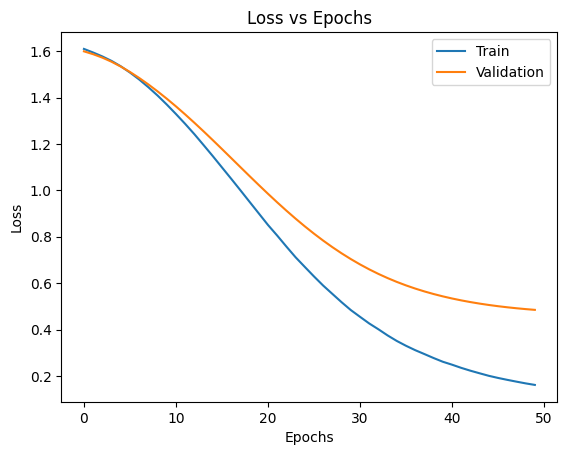

In [19]:
# Plotting losses
plot_losses(train_losses, val_losses)

In [20]:
nn_model.evaluate_model(x_test, test_data_y)

Test Loss: 0.6125, Accuracy: 77.07%


### Tokenize

In [21]:
# Generating vocabulary
class Vocab():
    def __init__(self, data):
        self.data = data
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.generate_vocab()

    def generate_vocab(self):
        for text in self.data:
            for word in text.split():
                self.vocab.add(word)
        self.word2idx = {word: idx + 1 for idx, word in enumerate(self.vocab)}
        self.idx2word = {idx: word for idx, word in enumerate(self.vocab)}

In [22]:
vocab = Vocab(preprocessed_train_data + preprocessed_test_data)

In [23]:
from nltk.tokenize import word_tokenize

# Tokenization function
def tokenize(text, vocab):
    tokenized_text = text.split()
    for i, token in enumerate(tokenized_text):
        tokenized_text[i] = vocab.word2idx[token]
    return tokenized_text

In [24]:
tokenized_train_data = [tokenize(text, vocab) for text in preprocessed_train_data]
tokenized_test_data = [tokenize(text, vocab) for text in preprocessed_test_data]

In [25]:
tokenized_train_data[0]

[103,
 18966,
 2758,
 10233,
 15506,
 3020,
 13312,
 27656,
 23464,
 13086,
 10233,
 15506,
 19380,
 32129,
 19986,
 20981,
 7927,
 26475,
 30654,
 26887,
 8619,
 10219,
 18543,
 7397,
 28925,
 14547,
 11794]

In [26]:
max_len = max([len(text) for text in tokenized_test_data + tokenized_train_data])
print(max_len)

7080


In [27]:
max_len = 256

In [28]:
import numpy as np

def pad_sequences(x, max_len):
    padded = np.zeros((max_len), dtype=np.int64)
    if len(x) > max_len: padded[:] = x[:max_len]
    else: padded[:len(x)] = x
    return padded

In [29]:
tokenized_train_data = [pad_sequences(x, max_len) for x in tokenized_train_data]
tokenized_test_data = [pad_sequences(x, max_len) for x in tokenized_test_data]

In [30]:
len(tokenized_train_data[0]), len(tokenized_test_data[0])

(256, 256)

In [31]:
from torch.utils.data import Dataset

class NewsDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [32]:
x_train, x_val, y_train, y_val = train_test_split(tokenized_train_data, train_data_y, test_size=0.2, random_state=42)

trainset = NewsDataset(x_train, y_train)
valset = NewsDataset(x_val, y_val)
testset = NewsDataset(tokenized_test_data, test_data_y)

In [33]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)

### Recurrent Neural Network (RNN)

In [34]:
def rnn_train(model, x_train, y_train, lr=1e-3, device=torch.device('cpu'), epochs=10):
    # Criterion and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Tracking losses
    train_losses = []
    val_losses = []

    # Training
    for epoch in range(epochs):
        model.train()

        epoch_losses = 0

        for batch_x, batch_y in tqdm(train_loader):
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            batch_y_preds, _ = model(batch_x)

            loss = criterion(batch_y_preds, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_losses += (len(batch_y)*loss.item())

        train_loss = epoch_losses/len(train_loader.dataset)
        train_losses.append(train_loss)

        # Evaluation on val set
        model.eval()
        correctly_labelled = 0
        with torch.no_grad():
            val_epoch_losses = 0
            for val_batch_x, val_batch_y in tqdm(val_loader):
                val_batch_x = val_batch_x.to(device)
                val_batch_y = val_batch_y.to(device)

                val_batch_y_preds, _ = model(val_batch_x)
                val_loss = criterion(val_batch_y_preds, val_batch_y)
                val_epoch_losses += (len(val_batch_y)*val_loss.item())

                correctly_labelled += (val_batch_y_preds.argmax(dim=1) == val_batch_y).sum().item()

            val_loss = val_epoch_losses/len(val_loader.dataset)
            val_losses.append(val_loss)
        print(f'Epoch: {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss={val_loss:.4f}. Accuracy: {correctly_labelled/len(val_loader.dataset)*100:.4f}%')

    return train_losses, val_losses

In [35]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers):
        super(RNN, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_layers)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def initialize_hidden_state(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_dim)

    def forward(self, x):
        # x = (batch_size, sequence_length)
        x = self.embedding(x) # (batch_size, sequence_length, embedding_dim)
        x = x.permute(1, 0, 2) # (sequence_length, batch_size, embedding_dim)
        self.hidden = self.initialize_hidden_state(x.shape[1]).to(x.device) # (num_layers, batch_size, hidden_dim)
        x, self.hidden = self.rnn(x, self.hidden)
        x = x[-1, :, : ]
        x = self.dropout(x)
        x = self.fc(x)
        return x, self.hidden

In [36]:
rnn = RNN(vocab_size=len(vocab.word2idx), embedding_dim=256, hidden_dim=512, output_dim=len(categories), num_layers=4)
rnn = rnn.to(device)
rnn = nn.DataParallel(rnn, device_ids=(0, 1)).to(device)
rnn_train_losses, rnn_val_losses = rnn_train(rnn, x_train, y_train, lr=1e-3, device=device, epochs=20)

100%|██████████| 17/17 [00:00<00:00, 47.20it/s]


125
Epoch: 1/20, Train Loss: 1.7426, Val Loss=1.6260. Accuracy: 23.7643%


100%|██████████| 17/17 [00:00<00:00, 52.62it/s]


122
Epoch: 2/20, Train Loss: 1.7106, Val Loss=1.6144. Accuracy: 23.1939%


100%|██████████| 17/17 [00:00<00:00, 52.41it/s]


125
Epoch: 3/20, Train Loss: 1.7037, Val Loss=1.6122. Accuracy: 23.7643%


100%|██████████| 17/17 [00:00<00:00, 51.87it/s]


117
Epoch: 4/20, Train Loss: 1.6871, Val Loss=1.6271. Accuracy: 22.2433%


100%|██████████| 17/17 [00:00<00:00, 51.22it/s]


76
Epoch: 5/20, Train Loss: 1.6817, Val Loss=1.6483. Accuracy: 14.4487%


100%|██████████| 17/17 [00:00<00:00, 51.54it/s]


103
Epoch: 6/20, Train Loss: 1.6679, Val Loss=1.6470. Accuracy: 19.5817%


100%|██████████| 17/17 [00:00<00:00, 51.65it/s]


123
Epoch: 7/20, Train Loss: 1.6479, Val Loss=1.6272. Accuracy: 23.3840%


100%|██████████| 17/17 [00:00<00:00, 46.27it/s]


102
Epoch: 8/20, Train Loss: 1.6676, Val Loss=1.6034. Accuracy: 19.3916%


100%|██████████| 17/17 [00:00<00:00, 50.23it/s]


114
Epoch: 9/20, Train Loss: 1.6589, Val Loss=1.6870. Accuracy: 21.6730%


100%|██████████| 17/17 [00:00<00:00, 51.87it/s]


120
Epoch: 10/20, Train Loss: 1.6625, Val Loss=1.6036. Accuracy: 22.8137%


100%|██████████| 17/17 [00:00<00:00, 50.80it/s]


125
Epoch: 11/20, Train Loss: 1.6630, Val Loss=1.6023. Accuracy: 23.7643%


100%|██████████| 17/17 [00:00<00:00, 51.44it/s]


121
Epoch: 12/20, Train Loss: 1.6513, Val Loss=1.5954. Accuracy: 23.0038%


100%|██████████| 17/17 [00:00<00:00, 50.81it/s]


118
Epoch: 13/20, Train Loss: 1.6602, Val Loss=1.6245. Accuracy: 22.4335%


100%|██████████| 17/17 [00:00<00:00, 50.81it/s]


120
Epoch: 14/20, Train Loss: 1.6427, Val Loss=1.6107. Accuracy: 22.8137%


100%|██████████| 17/17 [00:00<00:00, 49.45it/s]


118
Epoch: 15/20, Train Loss: 1.6632, Val Loss=1.6031. Accuracy: 22.4335%


100%|██████████| 17/17 [00:00<00:00, 49.54it/s]


131
Epoch: 16/20, Train Loss: 1.6784, Val Loss=1.6126. Accuracy: 24.9049%


100%|██████████| 17/17 [00:00<00:00, 51.35it/s]


125
Epoch: 17/20, Train Loss: 1.6607, Val Loss=1.6062. Accuracy: 23.7643%


100%|██████████| 17/17 [00:00<00:00, 47.04it/s]


119
Epoch: 18/20, Train Loss: 1.6578, Val Loss=1.6136. Accuracy: 22.6236%


100%|██████████| 17/17 [00:00<00:00, 50.18it/s]


116
Epoch: 19/20, Train Loss: 1.6285, Val Loss=1.6066. Accuracy: 22.0532%


100%|██████████| 17/17 [00:00<00:00, 49.29it/s]

120
Epoch: 20/20, Train Loss: 1.6304, Val Loss=1.5919. Accuracy: 22.8137%


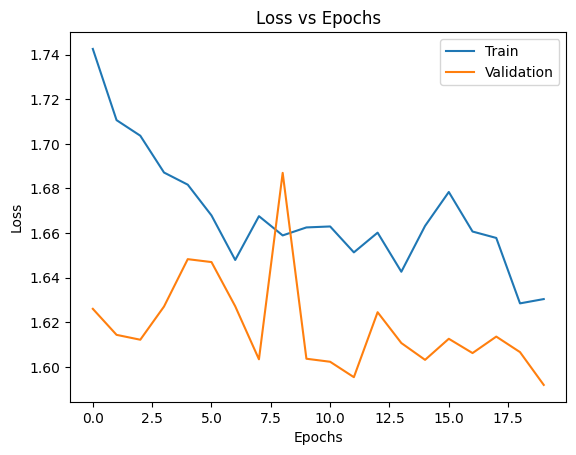

In [37]:
plot_losses(rnn_train_losses, rnn_val_losses)

### Gated Recurrent Unit (GRU)

In [38]:
class GRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers):
        super(GRU, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_layers)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def initialize_hidden_state(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_dim)

    def forward(self, x):
        # x = (batch_size, sequence_length)
        x = self.embedding(x) # (batch_size, sequence_length, embedding_dim)
        x = x.permute(1, 0, 2) # (sequence_length, batch_size, embedding_dim)
        self.hidden = self.initialize_hidden_state(x.shape[1]).to(device) # (num_layers, batch_size, hidden_dim)
        x, self.hidden = self.gru(x, self.hidden)
        x = x[-1, :, : ]
        x = self.dropout(x)
        x = self.fc(x)
        return x, self.hidden

In [39]:
gru = GRU(vocab_size=len(vocab.word2idx), embedding_dim=256, hidden_dim=512, output_dim=len(categories), num_layers=2)
gru = gru.to(device)
gru = nn.DataParallel(gru, device_ids=(0, 1)).to(device)
gru_train_losses, gru_val_losses = rnn_train(gru, x_train, y_train, lr=1e-3, device=device, epochs=15)

100%|██████████| 17/17 [00:00<00:00, 47.21it/s]


129
Epoch: 1/15, Train Loss: 1.7274, Val Loss=1.6518. Accuracy: 24.5247%


100%|██████████| 17/17 [00:00<00:00, 47.16it/s]


177
Epoch: 2/15, Train Loss: 1.6490, Val Loss=1.4844. Accuracy: 33.6502%


100%|██████████| 17/17 [00:00<00:00, 47.14it/s]


222
Epoch: 3/15, Train Loss: 1.4173, Val Loss=1.2716. Accuracy: 42.2053%


100%|██████████| 17/17 [00:00<00:00, 46.50it/s]


290
Epoch: 4/15, Train Loss: 1.0125, Val Loss=1.0842. Accuracy: 55.1331%


100%|██████████| 17/17 [00:00<00:00, 47.63it/s]


311
Epoch: 5/15, Train Loss: 0.6169, Val Loss=1.0749. Accuracy: 59.1255%


100%|██████████| 17/17 [00:00<00:00, 46.18it/s]


328
Epoch: 6/15, Train Loss: 0.4202, Val Loss=1.1087. Accuracy: 62.3574%


100%|██████████| 17/17 [00:00<00:00, 46.26it/s]


343
Epoch: 7/15, Train Loss: 0.2244, Val Loss=1.1259. Accuracy: 65.2091%


100%|██████████| 17/17 [00:00<00:00, 46.17it/s]


353
Epoch: 8/15, Train Loss: 0.1255, Val Loss=1.3522. Accuracy: 67.1103%


100%|██████████| 17/17 [00:00<00:00, 46.76it/s]


340
Epoch: 9/15, Train Loss: 0.1224, Val Loss=1.5837. Accuracy: 64.6388%


100%|██████████| 17/17 [00:00<00:00, 46.01it/s]


339
Epoch: 10/15, Train Loss: 0.0970, Val Loss=1.4488. Accuracy: 64.4487%


100%|██████████| 17/17 [00:00<00:00, 45.82it/s]


346
Epoch: 11/15, Train Loss: 0.0742, Val Loss=1.5789. Accuracy: 65.7795%


100%|██████████| 17/17 [00:00<00:00, 45.53it/s]


349
Epoch: 12/15, Train Loss: 0.0746, Val Loss=1.5144. Accuracy: 66.3498%


100%|██████████| 17/17 [00:00<00:00, 45.09it/s]


328
Epoch: 13/15, Train Loss: 0.0862, Val Loss=1.5675. Accuracy: 62.3574%


100%|██████████| 17/17 [00:00<00:00, 45.65it/s]


359
Epoch: 14/15, Train Loss: 0.0739, Val Loss=1.5137. Accuracy: 68.2510%


100%|██████████| 17/17 [00:00<00:00, 46.14it/s]

349
Epoch: 15/15, Train Loss: 0.0626, Val Loss=1.7084. Accuracy: 66.3498%


In [40]:
# gru_train_losses_cont, gru_val_losses_cont = rnn_train(gru, x_train, y_train, lr=1e-3, device=device, epochs=5)
# gru_train_losses += gru_train_losses_cont
# gru_val_losses += gru_val_losses_cont

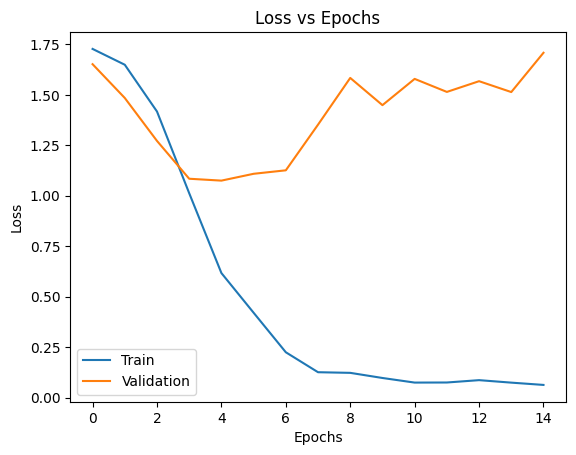

In [41]:
plot_losses(gru_train_losses, gru_val_losses)

### Long Short Term Memory (LSTM)

In [42]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers):
        super(LSTM, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_layers)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def initialize_hidden_state(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_dim)

    def forward(self, x):
        # x = (batch_size, sequence_length)
        x = self.embedding(x) # (batch_size, sequence_length, embedding_dim)
        x = x.permute(1, 0, 2) # (sequence_length, batch_size, embedding_dim)
        self.hidden = self.initialize_hidden_state(x.shape[1]).to(device) # (num_layers, batch_size, hidden_dim)
        self.cell_state = self.initialize_hidden_state(x.shape[1]).to(device) # (num_layers, batch_size, hidden_dim)
        x, (self.hidden, self.cell_state) = self.lstm(x, (self.hidden, self.cell_state))
        x = x[-1, :, : ]
        x = self.dropout(x)
        x = self.fc(x)
        return x, self.hidden

In [62]:
lstm = LSTM(vocab_size=len(vocab.word2idx), embedding_dim=256, hidden_dim=512, output_dim=len(categories), num_layers=4)
lstm = nn.DataParallel(lstm, device_ids=[0, 1])
lstm = lstm.to(device)
lstm_train_losses, lstm_val_losses = rnn_train(lstm, x_train, y_train, lr=1e-2, device=device, epochs=20)

100%|██████████| 17/17 [00:00<00:00, 21.80it/s]


129
Epoch: 1/20, Train Loss: 1.8130, Val Loss=1.6374. Accuracy: 24.5247%


100%|██████████| 17/17 [00:00<00:00, 21.37it/s]


112
Epoch: 2/20, Train Loss: 1.7669, Val Loss=1.6521. Accuracy: 21.2928%


100%|██████████| 17/17 [00:00<00:00, 20.73it/s]


112
Epoch: 3/20, Train Loss: 1.7504, Val Loss=1.6789. Accuracy: 21.2928%


100%|██████████| 17/17 [00:00<00:00, 20.40it/s]


118
Epoch: 4/20, Train Loss: 1.7844, Val Loss=1.6004. Accuracy: 22.4335%


100%|██████████| 17/17 [00:00<00:00, 20.75it/s]


97
Epoch: 5/20, Train Loss: 1.7774, Val Loss=1.7681. Accuracy: 18.4411%


100%|██████████| 17/17 [00:00<00:00, 21.15it/s]


118
Epoch: 6/20, Train Loss: 1.8108, Val Loss=1.7012. Accuracy: 22.4335%


100%|██████████| 17/17 [00:00<00:00, 21.30it/s]


129
Epoch: 7/20, Train Loss: 1.7163, Val Loss=1.6118. Accuracy: 24.5247%


100%|██████████| 17/17 [00:00<00:00, 21.54it/s]


112
Epoch: 8/20, Train Loss: 1.7561, Val Loss=1.6635. Accuracy: 21.2928%


100%|██████████| 17/17 [00:00<00:00, 21.71it/s]


112
Epoch: 9/20, Train Loss: 1.7592, Val Loss=1.6365. Accuracy: 21.2928%


100%|██████████| 17/17 [00:00<00:00, 21.53it/s]


118
Epoch: 10/20, Train Loss: 1.7607, Val Loss=1.6841. Accuracy: 22.4335%


100%|██████████| 17/17 [00:00<00:00, 21.53it/s]


97
Epoch: 11/20, Train Loss: 1.7144, Val Loss=1.7795. Accuracy: 18.4411%


100%|██████████| 17/17 [00:00<00:00, 21.52it/s]


118
Epoch: 12/20, Train Loss: 1.7427, Val Loss=1.6705. Accuracy: 22.4335%


100%|██████████| 17/17 [00:00<00:00, 21.35it/s]


112
Epoch: 13/20, Train Loss: 1.7548, Val Loss=1.6725. Accuracy: 21.2928%


100%|██████████| 17/17 [00:00<00:00, 21.04it/s]


70
Epoch: 14/20, Train Loss: 1.8020, Val Loss=1.7681. Accuracy: 13.3080%


100%|██████████| 17/17 [00:00<00:00, 21.26it/s]


112
Epoch: 15/20, Train Loss: 1.7497, Val Loss=1.7591. Accuracy: 21.2928%


100%|██████████| 17/17 [00:00<00:00, 21.36it/s]


112
Epoch: 16/20, Train Loss: 1.7511, Val Loss=1.6912. Accuracy: 21.2928%


100%|██████████| 17/17 [00:00<00:00, 21.27it/s]


129
Epoch: 17/20, Train Loss: 1.7581, Val Loss=1.6088. Accuracy: 24.5247%


100%|██████████| 17/17 [00:00<00:00, 21.31it/s]


112
Epoch: 18/20, Train Loss: 1.7375, Val Loss=1.6344. Accuracy: 21.2928%


100%|██████████| 17/17 [00:00<00:00, 21.37it/s]


118
Epoch: 19/20, Train Loss: 1.7491, Val Loss=1.7249. Accuracy: 22.4335%


100%|██████████| 17/17 [00:00<00:00, 21.24it/s]

112
Epoch: 20/20, Train Loss: 1.7678, Val Loss=1.6965. Accuracy: 21.2928%


In [ ]:
# lstm_train_losses_cont, lstm_val_losses_cont = rnn_train(lstm, x_train, y_train, lr=1e-3, device=device, epochs=5)
# lstm_train_losses += lstm_train_losses_cont
# lstm_val_losses += lstm_val_losses_cont

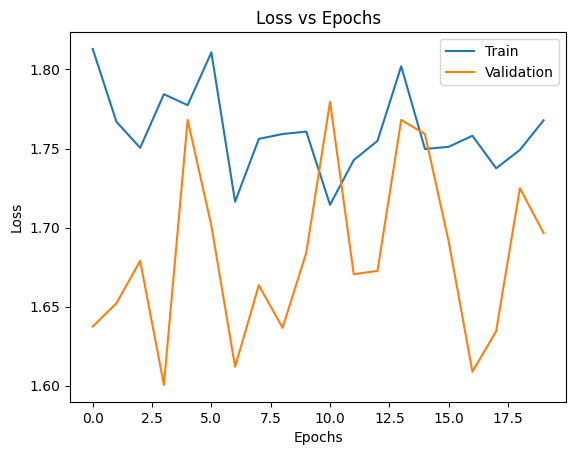

In [63]:
plot_losses(lstm_train_losses, lstm_val_losses)

In [66]:
torch.save(rnn.state_dict(), 'rnn.pt')
torch.save(gru.state_dict(), 'gru.pt')
torch.save(lstm.state_dict(), 'lstm.pt')

### Evaluation

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

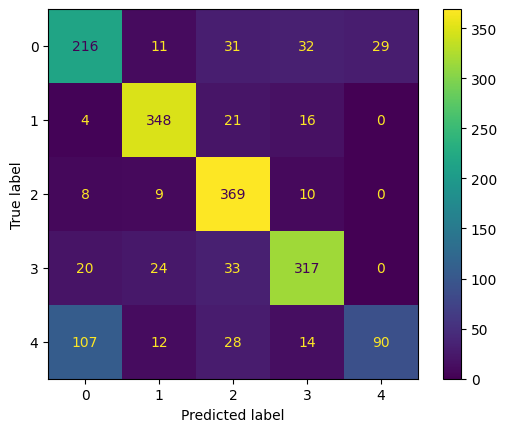

In [48]:
# Naive Bayes
y_pred = clf.predict(x_test)
cm = confusion_matrix(test_data_y, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

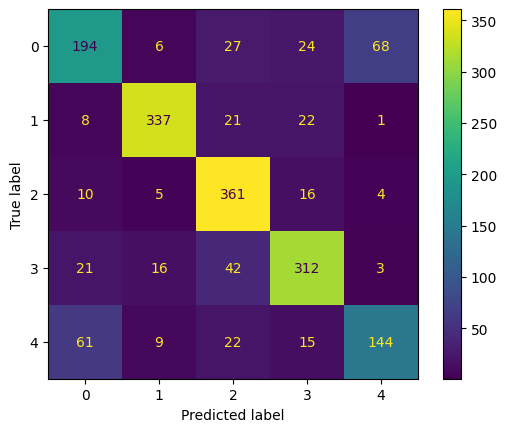

In [49]:
# NN
x_test_tensor = torch.tensor(x_test.toarray(), dtype=torch.float32).to(device)
y_pred = nn_model(x_test_tensor).argmax(dim=1).cpu().detach().numpy()
cm = confusion_matrix(test_data_y, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [50]:
test_loader = DataLoader(testset, shuffle=True)

100%|██████████| 1749/1749 [00:22<00:00, 79.37it/s]


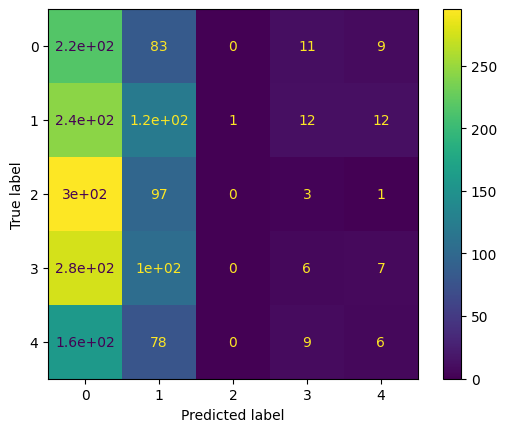

In [53]:
# RNN
num_classes = len(categories)
cm = np.zeros(shape=(num_classes, num_classes))
rnn.eval()
with torch.no_grad():
    for test_batch_x, test_batch_y in tqdm(test_loader):
        test_batch_x = test_batch_x.to(device)
                
        output, _ = rnn(test_batch_x)
                        
        test_batch_y_preds = output.argmax(dim=1).cpu().detach().numpy()
        cm_batch = confusion_matrix(test_batch_y, test_batch_y_preds, labels=range(num_classes))
        cm += cm_batch
        
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

100%|██████████| 1749/1749 [00:17<00:00, 98.72it/s] 


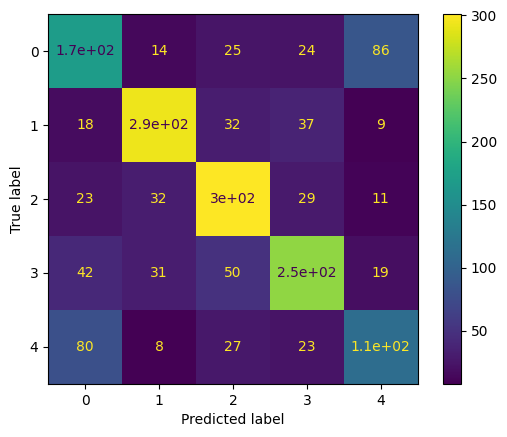

In [54]:
# GRU
num_classes = len(categories)
cm = np.zeros(shape=(num_classes, num_classes))
rnn.eval()
with torch.no_grad():
    for test_batch_x, test_batch_y in tqdm(test_loader):
        test_batch_x = test_batch_x.to(device)
                
        output, _ = gru(test_batch_x)
                        
        test_batch_y_preds = output.argmax(dim=1).cpu().detach().numpy()
        cm_batch = confusion_matrix(test_batch_y, test_batch_y_preds, labels=range(num_classes))
        cm += cm_batch
        
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

100%|██████████| 1749/1749 [00:38<00:00, 45.10it/s]


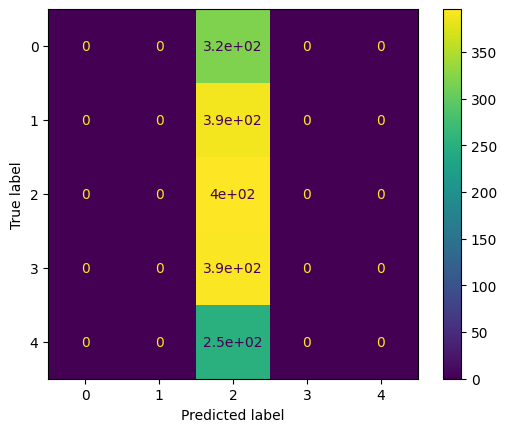

In [65]:
# LSTM
num_classes = len(categories)
cm = np.zeros(shape=(num_classes, num_classes))
rnn.eval()
with torch.no_grad():
    for test_batch_x, test_batch_y in tqdm(test_loader):
        test_batch_x = test_batch_x.to(device)
                
        output, _ = lstm(test_batch_x)
                        
        test_batch_y_preds = output.argmax(dim=1).cpu().detach().numpy()
        cm_batch = confusion_matrix(test_batch_y, test_batch_y_preds, labels=range(num_classes))
        cm += cm_batch
        
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()